https://jobs.zealpath.com/m/case/detail/429

### Build a model that predicts the number of hits per session. 
#### About the Data
- row_num: a number uniquely identifying each row.
- locale: the platform of the session.
- day_of_week: Mon-Fri, the day of the week of the session.
- hour_of_day: 00-23, the hour of the day of the session. 
- agent_id: the device used for the session.
- entry_page: describes the landing page of the session.
- path_id_set: shows all the locations that were visited during the session.
- traffic_type: indicates the channel the user cane through eg. search engine, email, ...
- session_duration: the duration in seconds of the session.
- hits: the number of interactions with the trivago page during the session.

In [1]:
%%javascript
Notification.requestPermission();
window.keep_me_updated = function(title, body){
    Notification.requestPermission();
    title = title || "Your job is done!!";
    body = body || "Go on, look at your results";
    var notification = new Notification(title, {
      body: body,
    }); 
}

<IPython.core.display.Javascript object>

In [2]:
%%javascript
window.keep_me_updated()

<IPython.core.display.Javascript object>

In [3]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sc
import sklearn as sk
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.tools import eval_measures
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from patsy import dmatrices

/home/wcasey17/anaconda3/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
scaler = StandardScaler()

#### correlation

In [5]:
# plt.figure(figsize=(16,10))
# sns.heatmap(df3.corr(), annot=True)
# plt.show()

In [6]:
df = pd.read_csv('/home/wcasey17/data/ml_ds_case_study.csv', delimiter=";")

#### Splitting the data into labeled and unlabeled data

In [7]:
df_final_test = df[df['hits'] == '\\N']
df_train = df[df['hits'] != '\\N']

In [8]:
session_duratio_mean = 564
df_train['session_durantion'] = df_train['session_durantion'].apply(lambda x: str(session_duratio_mean) if x == '\\N' else x)

/home/wcasey17/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [9]:
df_train['hits'] = df_train['hits'].astype('int')
df_train['session_durantion'] = df_train['session_durantion'].astype('int')

/home/wcasey17/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/wcasey17/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [10]:
df_train = df_train.drop(columns='row_num')

In [11]:
df_train.dtypes

locale               object
day_of_week          object
hour_of_day           int64
agent_id              int64
entry_page            int64
path_id_set          object
traffic_type          int64
session_durantion     int64
hits                  int64
dtype: object

In [12]:
df_train.sort_values('hits', ascending=False).head()

,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_durantion,hits
895214,L3,Monday,0,0,2701,382;103268;0,1,12255,4174
588662,L5,Monday,9,9,2100,31968;73264;31988;31987;31963;31964;407746;319...,1,5071,2603
156521,L6,Sunday,20,7,2100,73566;91304;0,1,5578,2521
143275,L3,Tuesday,18,8,2100,129796;146376;637968;0,1,10538,2384
713095,L3,Wednesday,11,2,2113,34812;34757;35094;0;35017,2,20277,2320


In [13]:
# plt.figure(figsize=(20, 8))
# sns.boxplot(x='hour_of_day', y='hits', data = df_train, hue='day_of_week', orient='v', showfliers=False)

<Figure size 2000x800 with 0 Axes>

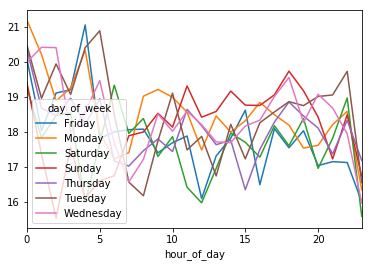

<Figure size 2000x800 with 0 Axes>

In [14]:
time_avg = df_train.groupby(['hour_of_day', 'day_of_week']).hits.mean().reset_index()
time_avg.pivot(index='hour_of_day', columns='day_of_week', values='hits').plot(kind='line')
plt.figure(figsize=(20, 8))

### Preprocessing: one hot encoding some stuff

In [15]:
[col for col in df_train.columns]

['locale',
 'day_of_week',
 'hour_of_day',
 'agent_id',
 'entry_page',
 'path_id_set',
 'traffic_type',
 'session_durantion',
 'hits']

In [16]:
collist = [
 'locale',
 'day_of_week',
 'hour_of_day',
 'traffic_type',

]
for c in collist:
    print(df_train.groupby(c)[c].count())
    print("\n")

locale
L1     26473
L2    107216
L3    215540
L4     86133
L5     72124
L6    111749
Name: locale, dtype: int64


day_of_week
Friday       79674
Monday       98953
Saturday     76335
Sunday       92707
Thursday     84577
Tuesday      95887
Wednesday    91102
Name: day_of_week, dtype: int64


hour_of_day
0     26437
1     23112
2     20490
3     16235
4     13319
5     12212
6     13351
7     15157
8     17236
9     19088
10    21458
11    24246
12    26898
13    29454
14    31764
15    33359
16    34104
17    34922
18    38611
19    40496
20    39408
21    35334
22    28241
23    24303
Name: hour_of_day, dtype: int64


traffic_type
1     196060
2     200774
3      34497
4      88238
6      91218
7       1913
10      6535
Name: traffic_type, dtype: int64




#### One hot encoding a few features

In [17]:
collist = [
 'locale',
 'day_of_week',
 'hour_of_day',
 'traffic_type',

]

# def add_ohe_col(col)

for col in collist:
    dummy_df = pd.get_dummies(df_train[col], prefix=col, drop_first=True)
    df_train = df_train.drop(columns=col).merge(dummy_df, left_index=True, right_index=True)

In [18]:
df_train.columns

Index(['agent_id', 'entry_page', 'path_id_set', 'session_durantion', 'hits',
       'locale_L2', 'locale_L3', 'locale_L4', 'locale_L5', 'locale_L6',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday',
       'hour_of_day_1', 'hour_of_day_2', 'hour_of_day_3', 'hour_of_day_4',
       'hour_of_day_5', 'hour_of_day_6', 'hour_of_day_7', 'hour_of_day_8',
       'hour_of_day_9', 'hour_of_day_10', 'hour_of_day_11', 'hour_of_day_12',
       'hour_of_day_13', 'hour_of_day_14', 'hour_of_day_15', 'hour_of_day_16',
       'hour_of_day_17', 'hour_of_day_18', 'hour_of_day_19', 'hour_of_day_20',
       'hour_of_day_21', 'hour_of_day_22', 'hour_of_day_23', 'traffic_type_2',
       'traffic_type_3', 'traffic_type_4', 'traffic_type_6', 'traffic_type_7',
       'traffic_type_10'],
      dtype='object')

## Preprocessing: session_durantion

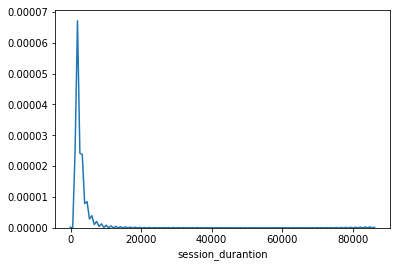

In [19]:
sns.distplot(df_train[df_train['session_durantion'] > 0].session_durantion, hist=False)

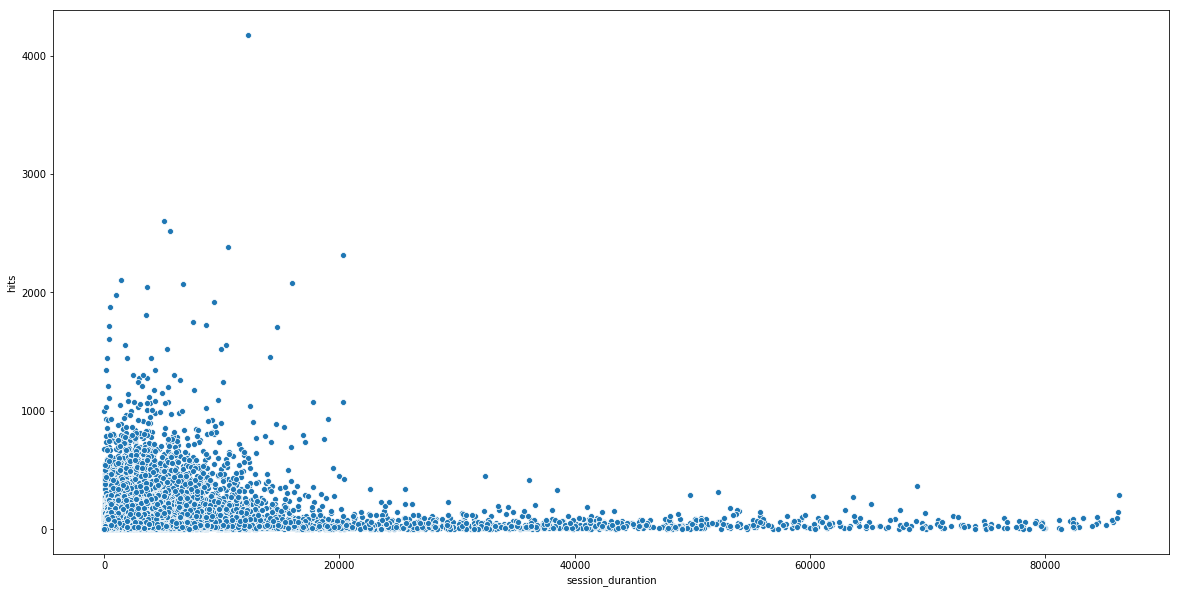

In [20]:
plt.figure(figsize=(20,10))
sns.scatterplot(x = 'session_durantion', y= 'hits', data = df_train[['hits', 'session_durantion']])

In [21]:
# df_train[['hits__standard', 'session_durantion__standard']] = pd.DataFrame(scaler.fit_transform(df_train[['hits', 'session_durantion']].to_numpy()))

In [22]:
# df_train[['hits__log', 'session_durantion__log']] = df_train[['hits', 'session_durantion']].apply(lambda x: np.log(x))

In [23]:
# plt.figure(figsize=(20,10))
# sns.lmplot(x = 'session_durantion__log', y= 'hits__log', data = df_train[['hits__log', 'session_durantion__log']])

In [24]:
# sns.boxplot(df_train['hits__log'])

In [25]:
# sns.boxplot(df_train['hits__log'], showfliers=False)

In [26]:
# df_train['log_hits'] = df_train.hits.apply(lambda x: np.log(x))

In [27]:
# sns.boxplot(df_train.log_hits)

## Preprocessing: Agent_id

In [28]:
df_train.head(10)

,agent_id,entry_page,path_id_set,session_durantion,hits,locale_L2,locale_L3,locale_L4,locale_L5,locale_L6,...,hour_of_day_20,hour_of_day_21,hour_of_day_22,hour_of_day_23,traffic_type_2,traffic_type_3,traffic_type_4,traffic_type_6,traffic_type_7,traffic_type_10
1,10,2113,31965;0,49,14,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,2,2100,0;78464,1892,14,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3,8,2113,51462,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,10,2116,31931;0,2,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,8,2100,0,0,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,10,2166,0,0,2,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7,1,2113,34302;0,2,3,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8,10,2111,34227;0,4,3,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9,9,2113,42172;0;38715,724,45,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
10,8,2100,0;45069;44232,896,39,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [29]:
tojoin = df_train.groupby(['agent_id']).agg({'hits': np.average}).rename(columns={'hits':'agent_id_average'})

In [30]:
df_train = df_train.merge(tojoin, left_on='agent_id', right_index=True)

In [31]:
df_train.groupby(['agent_id']).agg({'agent_id': len, 'hits': [np.sum, np.average]})

hits            agent_id
              sum    average      len
agent_id                             
0           97087  27.402484     3543
1         2351752  19.068929   123329
2          693233  18.239134    38008
3             146   1.738095       84
4             206   1.364238      151
5             138   1.243243      111
7          405798  23.433505    17317
8          977944  15.443497    63324
9         2426552  18.770466   129275
10        3363069  17.551178   191615
11          21666  16.769350     1292
12          27680  11.252033     2460
13         603850  18.798057    32123
14         305837  18.496341    16535
15           1360  20.000000       68

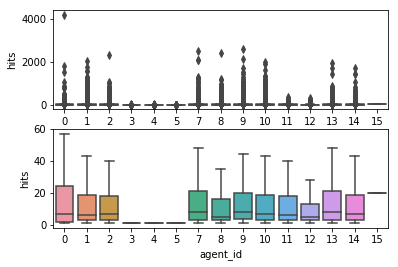

In [32]:
x = 'agent_id'
plt.subplot(2, 1, 1)
sns.boxplot(x=x, y='hits', data=df_train, showfliers=True, orient='v')
plt.subplot(2, 1, 2)
sns.boxplot(x=x, y='hits', data=df_train, showfliers=False)
plt.show()


In [33]:
df_train = df_train.drop(columns='agent_id')

## Preprocessing: entry_page

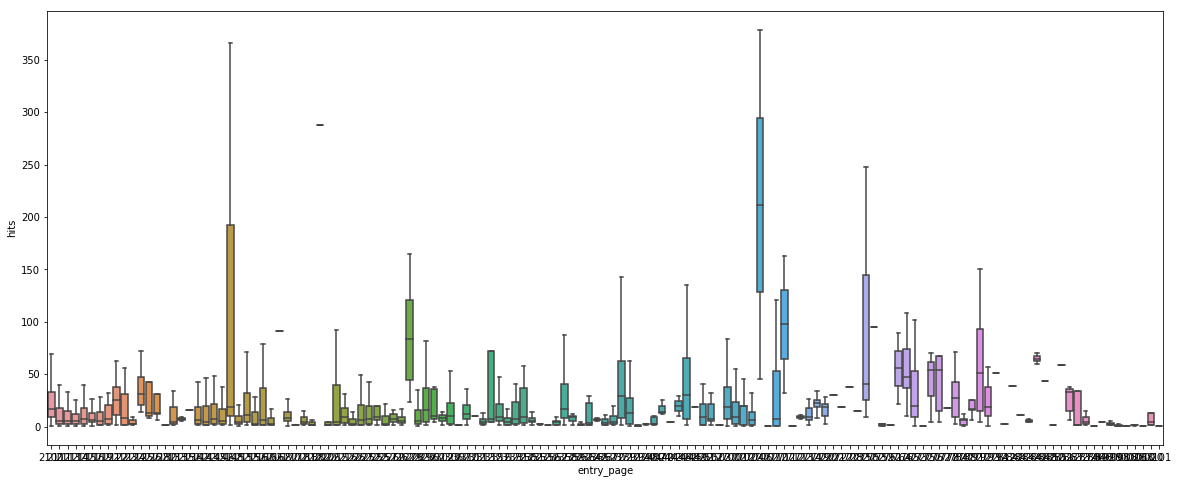

In [34]:
x = 'entry_page'
# plt.subplot(2, 1, 1)
# sns.boxplot(x=x, y='hits', data=df_train, showfliers=True, orient='v')
# plt.subplot(2, 1, 2)
plt.figure(figsize=(20, 8))
sns.boxplot(x=x, y='hits', data=df_train, showfliers=False)
plt.show()

In [35]:
entry_page = df_train.groupby(['entry_page']).agg({'entry_page': len, 'hits': [np.average, np.std]})

In [36]:
entry_page.columns = entry_page.columns.droplevel(0)

In [37]:
new_cols = {w:"entry_page_" + w for w in entry_page.columns}

In [38]:
entry_page = entry_page.rename(columns=new_cols)

In [39]:
entry_page = entry_page.fillna(0)

In [40]:
entry_page = entry_page.reset_index()

In [41]:
entry_page[['entry_page_average__standard', 'entry_page_std__standard', 'entry_page_len__standard']] = pd.DataFrame(scaler.fit_transform(entry_page[['entry_page_average', 'entry_page_std', 'entry_page_len']].to_numpy()))

In [42]:
entry_page

,entry_page,entry_page_len,entry_page_average,entry_page_std,entry_page_average__standard,entry_page_std__standard,entry_page_len__standard
0,2100,110762,30.622723,54.605291,0.060926,0.323052,4.568862
1,2111,51932,17.250231,36.600361,-0.297400,0.002208,2.038920
2,2113,205968,14.629467,32.382016,-0.367625,-0.072962,8.663126
3,2114,44589,11.881451,23.421736,-0.441260,-0.232633,1.723140
4,2115,10655,17.433881,40.207986,-0.292479,0.066495,0.263833
5,2116,125338,12.814988,27.249339,-0.416245,-0.164426,5.195692
6,2119,144,14.520833,30.868992,-0.370536,-0.099924,-0.188185
7,2121,21,28.904762,61.392919,0.014892,0.444006,-0.193475
8,2122,7,26.857143,21.271488,-0.039975,-0.270950,-0.194077
9,2123,26,44.923077,108.261137,0.444114,1.279189,-0.193260


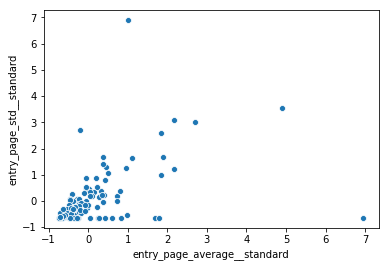

In [43]:
sns.scatterplot(x = 'entry_page_average__standard', y = 'entry_page_std__standard', data=entry_page[['entry_page_average__standard', 'entry_page_std__standard']])

In [44]:
Kmean = KMeans(n_clusters=5)

In [45]:
kmeanfit = Kmean.fit(entry_page[['entry_page_average__standard', 'entry_page_std__standard', 'entry_page_len__standard']].fillna(0))

In [46]:
entry_page['entry_page_clusters'] = Kmean.labels_

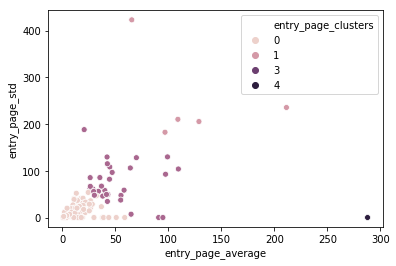

In [47]:
sns.scatterplot(x = 'entry_page_average', y = 'entry_page_std', hue='entry_page_clusters', data=entry_page[['entry_page_average', 'entry_page_std', 'entry_page_clusters']])

In [48]:
entry_page['entry_page_clusters'] = entry_page['entry_page_clusters'].astype('str')

In [49]:
df_train = df_train.merge(entry_page[['entry_page_clusters', 'entry_page']], left_on='entry_page', right_on='entry_page', how='inner')

In [50]:
df_train = df_train.drop(columns='entry_page')

In [51]:
col = 'entry_page_clusters'
dummy_df = pd.get_dummies(df_train[col], prefix=col, drop_first=True)
df_train = df_train.drop(columns=col).merge(dummy_df, left_index=True, right_index=True)

In [52]:
df = df_train.copy()

In [53]:
df = df.drop(columns='path_id_set')

In [61]:
dfcorr = df.corr()

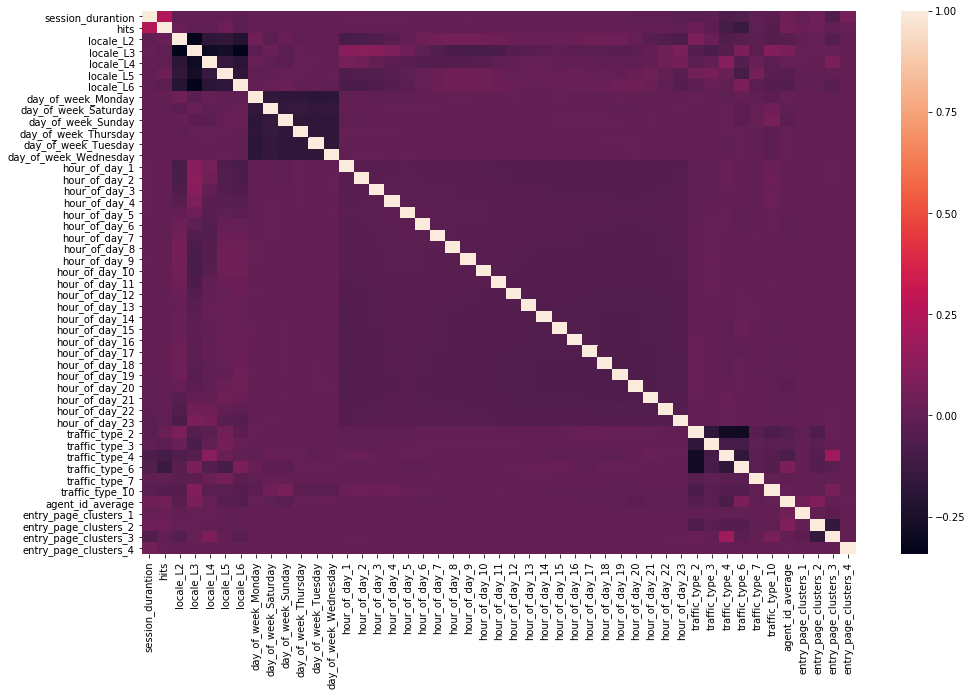

In [60]:
plt.figure(figsize=(16,10))
sns.heatmap(dfcorr, annot=False)
plt.show()

### Split the data

In [62]:

labels = np.array(df['hits'])

features= df.drop('hits', axis = 1)

feature_list = list(df.columns)

features = np.array(df)

In [71]:
from sklearn.cross_validation import KFold, cross_val_score

In [74]:
cv = KFold(n = 12, n_folds=10, random_state=42, shuffle=False)

In [75]:
for train_set,test_set in cv:
    print(train_set, test_set)

[ 2  3  4  5  6  7  8  9 10 11 12 13 14] [0 1]
[ 0  1  4  5  6  7  8  9 10 11 12 13 14] [2 3]
[ 0  1  2  3  6  7  8  9 10 11 12 13 14] [4 5]
[ 0  1  2  3  4  5  8  9 10 11 12 13 14] [6 7]
[ 0  1  2  3  4  5  6  7 10 11 12 13 14] [8 9]
[ 0  1  2  3  4  5  6  7  8  9 11 12 13 14] [10]
[ 0  1  2  3  4  5  6  7  8  9 10 12 13 14] [11]
[ 0  1  2  3  4  5  6  7  8  9 10 11 13 14] [12]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 14] [13]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] [14]


In [56]:

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = sk.cross_validation.train_test_split(features, labels, test_size = 0.25, random_state = 42)
train_features, test_features, train_labels, test_labels = sk.cross_validation.train_test_split(test_features, test_labels, test_size = 0.25, random_state = 42)

In [57]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (464426, 47)
Training Labels Shape: (464426,)
Testing Features Shape: (154809, 47)
Testing Labels Shape: (154809,)


## Train the model

In [79]:
#n_estimators = 1000 trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42, )

rf.fit(train_features, train_labels);

In [80]:
# from sklearn.externals import joblib
# # Output a pickle file for the model
# joblib.dump(clf, 'saved_model.pkl') 

In [85]:
predictions_train = rf.predict(train_features)
predictions_test = rf.predict(test_features)

# errors = (predictions - test_labels)



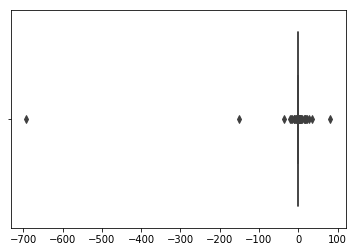

In [87]:
sns.boxplot((predictions_train - train_labels))

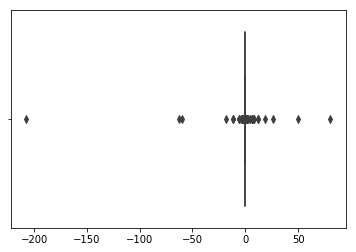

In [88]:
sns.boxplot((predictions_test - test_labels))

In [89]:
print("train")
print("RMSE: ", eval_measures.rmse(predictions_train, train_labels))
print("MSE: ", eval_measures.mse(predictions_train, train_labels))

print("\n\n")
print("test")
print("RMSE: ", eval_measures.rmse(predictions_test, test_labels))
print("MSE: ", eval_measures.mse(predictions_test, test_labels))

train
RMSE:  1.055185240054408
MSE:  1.1134158908286784



test
RMSE:  0.6327646207712796
MSE:  0.4003910652998212


In [90]:
# # Calculate mean absolute percentage error (MAPE)
# mape = 100 * (errors / test_labels)
# # Calculate and display accuracy
# accuracy = 100 - np.mean(mape)
# print('Accuracy:', round(accuracy, 2), '%.')

In [49]:
# corr = hour_of_day.corr()
# # Generate a mask for the upper triangle
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(11, 9))

# # Generate a custom diverging colormap
# cmap = sns.diverging_palette(220, 10, as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [50]:
# df_train2 = df_train.copy()
# df_train2['hour_of_day'] = df_train2['hour_of_day'].astype('str')

In [51]:
# df_train['hour_of_day'] = df_train['hour_of_day'].astype('str')

### Baseline Models

In [94]:
# model = ols('hits ~ I(hour_of_day**3)', data = df_train.sample(n=100000)).fit()
# ols_model = ols('hits ~ entry_page_clusters', data = df_train).fit()
ols_model = sm.OLS(train_labels, train_features).fit()
predictions_ols_train = ols_model.predict(train_features)
predictions_ols_test = ols_model.predict(test_features)
print(ols_model.summary())
print("RMSE: ", eval_measures.rmse(predictions_ols_train, train_labels))
# print("MSE: ", model_baseline.mse_total)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.634e+31
Date:                Sun, 23 Jun 2019   Prob (F-statistic):               0.00
Time:                        06:23:10   Log-Likelihood:             1.2561e+07
No. Observations:              464426   AIC:                        -2.512e+07
Df Residuals:                  464379   BIC:                        -2.512e+07
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          2.211e-16   3.41e-19    649.265      0.0

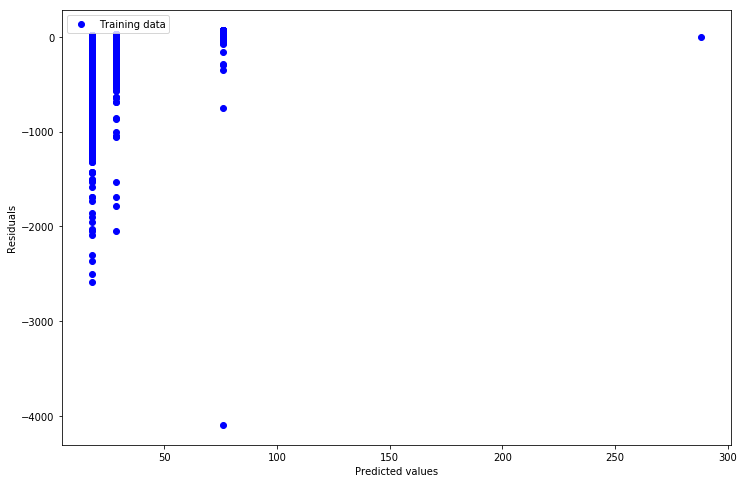

In [57]:
residuals = y_pred - df_train['hits']
plt.figure(figsize=(12,8))
plt.scatter(y_pred, residuals, c='blue', marker='o', label='Training data')
# plt.scatter(y_test_pred, y_test_pred - y_test, c='orange', marker='*', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
# plt.hlines(y=0, xmin=0, xmax=5000, lw=2, color='k')
# plt.xlim([1500, 4000])
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(ols_model, ax=ax, criterion="cooks")

/home/wcasey17/.local/lib/python3.5/site-packages/statsmodels/stats/outliers_influence.py:323: RuntimeWarning: invalid value encountered in sqrt
  return  self.results.resid / sigma / np.sqrt(1 - hii)
/home/wcasey17/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/wcasey17/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/wcasey17/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [59]:
# df_train['session_durantion__log2'] = df_train.session_durantion__log.apply(lambda x: 0 if str(x) == '-inf' else x)

In [66]:


# response, predictors = dmatrices(train_labels, train_features, return_type='dataframe')
poisson_model = sm.GLM(train_labels, train_features, family=sm.families.Poisson()).fit()
predictions_train = poisson_model.predict(train_features)
predictions_test = poisson_model.predict(test_features)
print(poisson_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:               464426
Model:                            GLM   Df Residuals:                   464379
Model Family:                 Poisson   Df Model:                           46
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -5.3606e+06
Date:                Sun, 23 Jun 2019   Deviance:                   8.8750e+06
Time:                        05:33:32   Pearson chi2:                 2.98e+07
No. Iterations:                    15   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          3.865e-05   5.94e-08    650.326      0.000    3.85e-05    3.88e-05
x2             0.0031   1.05e-06   2943.904      0.0

In [69]:
print("train")
print("RMSE: ", eval_measures.rmse(predictions_train, train_labels))
print("MSE: ", eval_measures.mse(predictions_train, train_labels))

print("\n\n")
print("test")
print("RMSE: ", eval_measures.rmse(predictions_test, test_labels))
print("MSE: ", eval_measures.mse(predictions_test, test_labels))

train
RMSE:  142.01401519392928
MSE:  20167.980511501573



test
RMSE:  345.2068348178659
MSE:  119167.75880496936


In [75]:
residuals.sort()

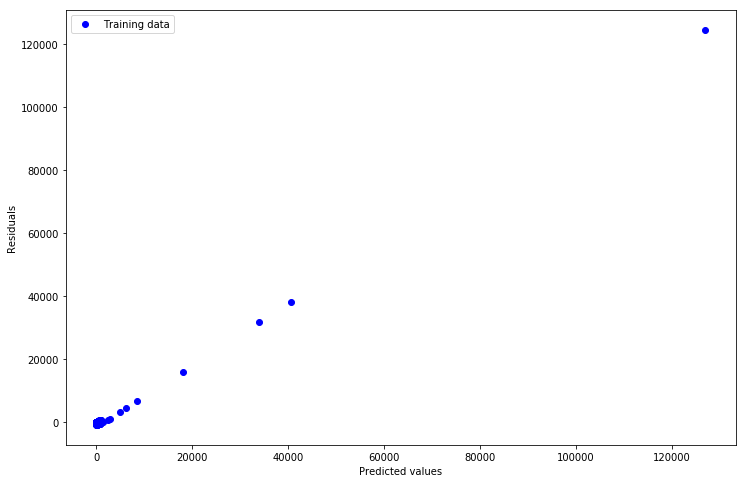

In [76]:
residuals = predictions_test - test_labels
plt.figure(figsize=(12,8))
plt.scatter(predictions_test, residuals, c='blue', marker='o', label='Training data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.show()